In [1]:
import torch
import torch.nn as nn
from torch.nn import Linear, ReLU
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import MessagePassing, GCNConv, GINConv, SAGEConv, GATConv, global_mean_pool
from torch_geometric.data import DataLoader, Data
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax

from sklearn.model_selection import StratifiedKFold, KFold
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.debugger import set_trace


/nasdata3/kyj/anaconda3/envs/graphcl/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
runseed = 5
device_num = 4
device = torch.device("cuda:" + str(device_num)) if torch.cuda.is_available() else torch.device("cpu")

In [3]:
torch.manual_seed(runseed)
np.random.seed(runseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(runseed)

In [4]:
sub_list = open('/nasdata4/kyj0305/ABIDE/Download_preprocess/roi_aal_1d/passedQC/list','r').read().split('\n')
sub_list.pop()
print(len(sub_list))
print(sub_list[0:5])
    

dataset = []
for sub in sub_list:
    with open(f'/nasdata4/kyj0305/ABIDE/Download_preprocess/roi_aal_1d/passedQC/ROICorrelation_FisherZ_{sub}.txt','r') as f:
        #l = pickle.load(f)
        #l = pickle.load(f)
        #l = torch.FloatTensor(l)
        x_np =[[float(num) for num in line.split(' ')] for line in f]
        x_np = np.array(x_np)
        np.fill_diagonal(x_np,0)
        x = np.arctanh(x_np)
        x = torch.FloatTensor(x_np)
        x = torch.transpose(x,0,1)
        
    with open(f'/nasdata4/kyj0305/ABIDE/Download_preprocess/y/{sub}.txt','r') as f:
        f = f.read()
        y = torch.LongTensor([int(f)])
        
    with open(f'/nasdata4/kyj0305/ABIDE/Download_preprocess/edge/edge_index20/ROICorrelation_FisherZ_{sub}_edge_index.txt') as f:
        edge_index = torch.LongTensor([[int(num) for num in line.split()] for line in f])
        edge_index_T = torch.transpose(edge_index,0,1)
        
    with open(f'/nasdata4/kyj0305/ABIDE/Download_preprocess/edge/edge_index20/ROICorrelation_FisherZ_{sub}_edge_attr.txt') as f:  
        edge_attr = torch.FloatTensor([[float(num) for num in line.split()] for line in f])

    my_data = Data(x=x, edge_index=edge_index_T, edge_attr=edge_attr, y=y)

    dataset.append(my_data)

print(edge_attr)

942
['Caltech_0051461', 'Caltech_0051463', 'Caltech_0051464', 'Caltech_0051465', 'Caltech_0051473']
tensor([[0.4916],
        [0.5287],
        [0.4397],
        ...,
        [0.4662],
        [0.4393],
        [0.4751]])


In [5]:
print(dataset[0])

Data(edge_attr=[2692, 1], edge_index=[2, 2692], x=[116, 116], y=[1])


KKI_0050794
13456


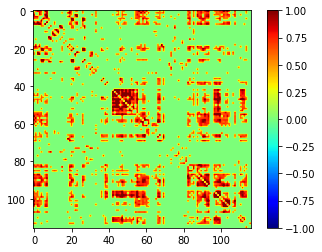

KKI_0050795
13456


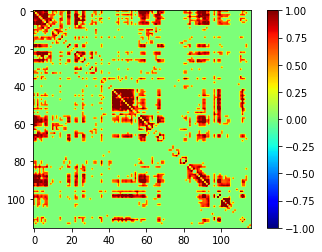

KKI_0050796
13456


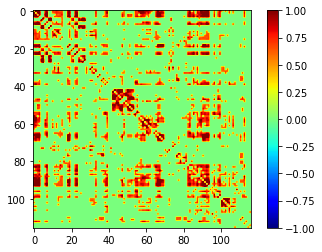

KKI_0050797
13456


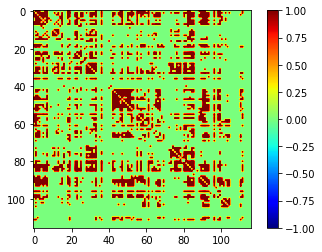

KKI_0050798
13456


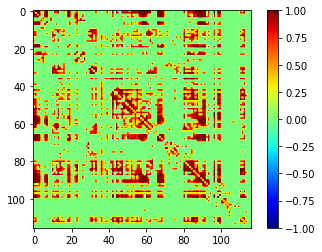

KKI_0050799
13456


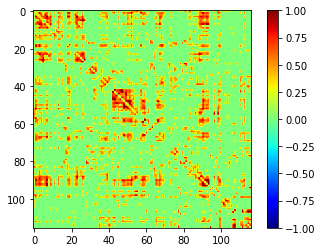

KKI_0050800
13456


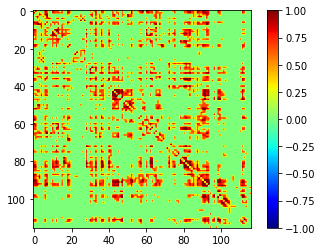

KKI_0050801
13456


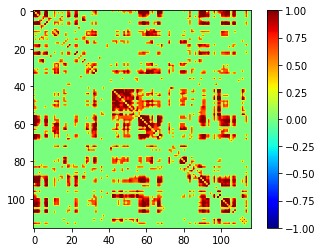

KKI_0050802
13456


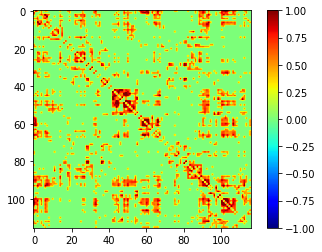

KKI_0050803
13456


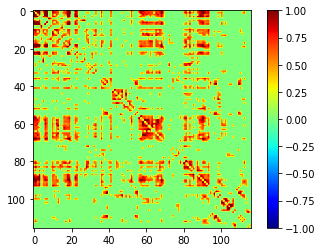

KKI_0050804
13456


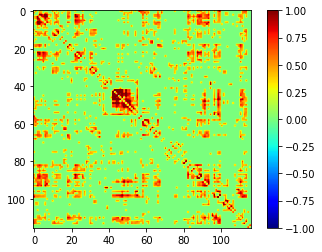

KKI_0050807
13456


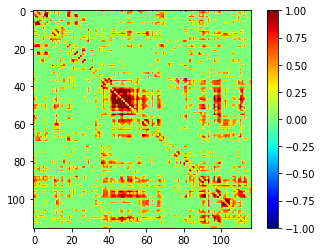

KKI_0050812
13456


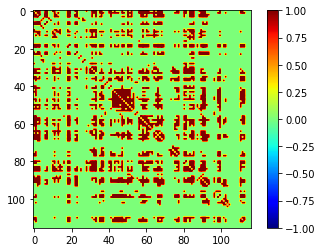

KKI_0050814
13456


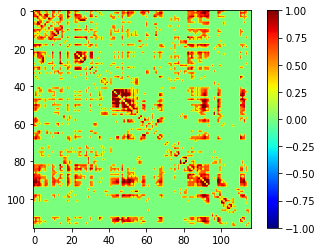

KKI_0050815
13456


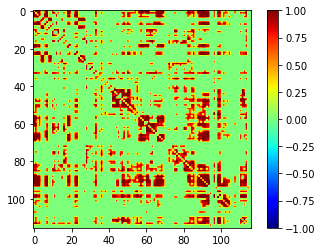

KKI_0050816
13456


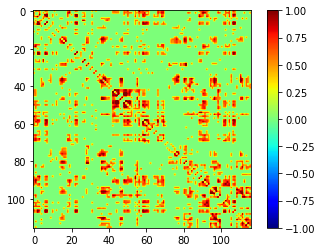

KKI_0050817
13456


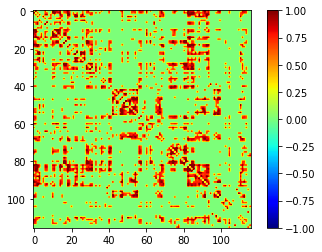

KKI_0050818
13456


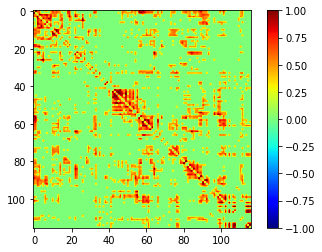

KKI_0050819
13456


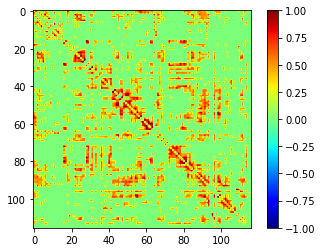

KKI_0050820
13456


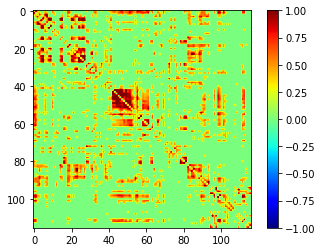

In [6]:

sub_list = open('/nasdata4/kyj0305/ABIDE/Download_preprocess/roi_aal_1d/passedQC/list','r').read().split('\n')
sub_list = sub_list[50:70]
for i in sub_list:
    print(i)
    with open(f'/nasdata4/kyj0305/ABIDE/Download_preprocess/roi_aal_1d/passedQC/ROICorrelation_FisherZ_{i}.txt','r') as f:
        x =np.array([[float(num) for num in line.split(' ')] for line in f])
        np.fill_diagonal(x,0)   
        a3 = x.reshape(-1)
        print(a3.shape[0] )
        threshold = int(a3.shape[0]*0.2)
        a3 = np.sort(a3)
        thresval = a3[-threshold]
        x[x<thresval] = 0
        x = np.arctanh(x)
        # for i in range(len(x)):
        #     for j in range(len(x)):
        #         if i > j : 
        #             x[i][j] = z_transform(x[i][j], 116)
        #             x[j][i] = z_transform(x[i][j], 116)
        #         else: 
        #             tmp=0
        plt.imshow(x, vmin=-1, vmax=1,cmap='jet')
        plt.colorbar()
        plt.show()
        


In [7]:
kfold = 1
y=[]
for i in range(len(dataset)):
    y.append(int(dataset[i].y))

if kfold == 1:
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=613)
    skf2 = StratifiedKFold(n_splits=9, shuffle=True, random_state=613)
else :
    skf = StratifiedKFold(n_splits=kfold, shuffle=True, random_state=613)
    skf2 = StratifiedKFold(n_splits=kfold-1, shuffle=True, random_state=613)

x_idx=[[i] for i in range(len(dataset))]

for train_val_index, test_index in skf.split(x_idx, y):
    train_val_dataset=[]
    train_dataset=[]
    val_dataset = []
    test_dataset=[]
    
    train_val_y = []
    
    for j in train_val_index:
        train_val_dataset.append(dataset[j])
        train_val_y += dataset[j].y.tolist()
    for j in test_index:
        test_dataset.append(dataset[j])
        
    train_val_x = [[i] for i in range(len(train_val_dataset))]
    for train_index, val_index in skf2.split(train_val_x, train_val_y):
        tmp=0
    for j in train_index:
        train_dataset.append(train_val_dataset[j])
    for j in val_index:
        val_dataset.append(train_val_dataset[j])   
        
print(len(train_dataset))

754


In [16]:
batch_size = 400
epochs = 500
lr = 0.0001
num_features = 116
num_classes = 2
decay = 0.00001
hidden_channals = 128
head = 2
dropout = 0.5

In [17]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.pooling = global_mean_pool
        self.linear = Linear(hidden_channels, 128)
        self.relu = ReLU()
        self.linear2 = Linear(128, out_channels)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, edge_index, edge_weight, batch):
        # x: Node feature matrix of shape [num_nodes, in_channels]
        # edge_index: Graph connectivity matrix of shape [2, num_edges]
        edge_index, _ = add_self_loops(edge_index, num_nodes = x.size(0))
        
        x = self.conv1(x, edge_index, edge_weight).relu()
        x = self.conv2(x, edge_index, edge_weight).relu()
        pooled = self.pooling(x, batch)
        x =  self.relu(self.dropout(self.linear(self.dropout(pooled))))
        return self.linear2(x)
    
class GIN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GINConv(in_channels, hidden_channels)
        self.conv2 = GINConv(hidden_channels, hidden_channels)
        self.pooling = global_mean_pool
        self.linear = Linear(hidden_channels, hidden_channels)
        self.relu = ReLU()
        self.linear2 = Linear(hidden_channels, out_channels)
        
    def forward(self, x, edge_index, batch):
        # x: Node feature matrix of shape [num_nodes, in_channels]
        # edge_index: Graph connectivity matrix of shape [2, num_edges]
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        pooled = self.pooling(x, batch)
        x =  self.relu(self.linear(pooled))
        return self.linear2(x)
    
    
class graphsage(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.pooling = global_mean_pool
        self.linear = Linear(hidden_channels, 256)
        self.relu = ReLU()
        self.linear2 = Linear(256, out_channels)
        
    def forward(self, x, edge_index, batch):
        self_loop_mask = edge_index[0] == edge_index[1]
        edge_index = edge_index[:, ~self_loop_mask]
        edge_index, _ = add_self_loops(edge_index, num_nodes = x.size(0))
        
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        pooled = self.pooling(x, batch)
        x =  self.relu(self.linear(pooled))
        return self.linear2(x)
    
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels ,heads=head)
        self.conv2 = GATConv(hidden_channels*head, hidden_channels ,heads=head)
        self.pooling = global_mean_pool
        self.linear = Linear(hidden_channels*head, 32)
        self.relu = ReLU()
        self.dropout1 = nn.Dropout(dropout)
        self.linear2 = Linear(32, out_channels)
        
    def forward(self, x, edge_index, batch):
        # x: Node feature matrix of shape [num_nodes, in_channels]
        # edge_index: Graph connectivity matrix of shape [2, num_edges]
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        pooled = self.pooling(x, batch)
        x =  self.relu(self.linear(pooled))
        x = self.dropout1(x)
        return self.linear2(x)
       


In [18]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader =  DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [19]:
criterion = nn.BCEWithLogitsLoss()

def train(model, device, train_loader, val_loader, optimizer, num_classes):
    with torch.autograd.detect_anomaly():
        model.train()
        running_loss = 0.0
        for step, batch in enumerate(tqdm(train_loader, desc="Iteration")):
            batch = batch.to(device)
            #pred = model(batch.x, batch.edge_index, batch.edge_attr[:,0], batch.batch)
            pred = model(batch.x, batch.edge_index, batch.batch)
            y = F.one_hot(batch.y, num_classes=num_classes)
            y = y.view(pred.shape).to(torch.float64)
            
            optimizer.zero_grad()
            loss = criterion(pred.double(), y.double())
            loss.backward()
            optimizer.step()
            running_loss += loss
        
        print(len(train_loader))
        running_loss = running_loss/(len(train_loader))
        
        model.eval()
        
        for i, data in enumerate(val_loader):
            data = data.to(device)
            #val_pred = model(data.x, data.edge_index, data.edge_attr[:,0], data.batch)
            val_pred = model(data.x, data.edge_index, data.batch)
            val_y = F.one_hot(data.y, num_classes=num_classes)
            val_y = val_y.view(val_pred.shape).to(torch.float64)
            
            val_loss = criterion(val_pred.double(), val_y.double())
    
    return loss.item(), val_loss.item() , val_y.double() , val_pred.double()

def eval(model, device, loader, num_classes):
    model.eval()
    y_true = []
    y_scores = []
    for step, batch in enumerate(tqdm(loader, desc="Iteration")):
        batch = batch.to(device)
        with torch.no_grad():
            #pred = model(batch.x, batch.edge_index, batch.edge_attr[:,0], batch.batch)
            pred = model(batch.x, batch.edge_index, batch.batch)
            
        y = F.one_hot(batch.y, num_classes=num_classes)
        y_true.append(y.view(pred.shape).detach().cpu())
        y_scores.append(pred.detach().cpu())
            
    y_true = torch.cat(y_true, dim = 0).numpy()
    y_scores = torch.cat(y_scores, dim = 0).numpy()

    roc_list = []
    fper_list = []
    tper_list = []

    for i in range(y_true.shape[1]):
        #AUC is only defined when there is at least one positive data.
        if np.sum(y_true[:,i] == 1) > 0 and np.sum(y_true[:,i] == 0) > 0:
            roc_list.append(roc_auc_score(y_true[:,i], y_scores[:,i]))
            fper, tper, _ = roc_curve(y_true[:,i], y_scores[:,i])
            #)
            fper_list.append(fper)
            tper_list.append(tper)
            
        else:
            roc_list.append(np.nan)
    
    y_pred_one_hot = []
    for i in range(len(y_scores)):
        if y_scores[i,0] < y_scores[i,1]:
            y_pred_new = 0
        else: y_pred_new = 1
        y_pred_one_hot.append(y_pred_new) 
    acc = accuracy_score(y_true[:,0], np.array(y_pred_one_hot))   
    cm = confusion_matrix(y_true[:,0],y_pred_one_hot)
        
    return np.array(roc_list),fper_list,tper_list, acc, cm
        
        

In [20]:
model = GAT(num_features, hidden_channals, num_classes)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
print(model)

GAT(
  (conv1): GATConv(116, 128, heads=2)
  (conv2): GATConv(256, 128, heads=2)
  (linear): Linear(in_features=256, out_features=32, bias=True)
  (relu): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (linear2): Linear(in_features=32, out_features=2, bias=True)
)


In [29]:
train_auc_list = []
val_auc_list = []
test_auc_list =  []
test_acc_list = []
train_acc_list = []
val_acc_list = []
#for roc plot
test_fper_list = []
test_tper_list= []
# for loss plot
loss_values = []
val_loss_values = []
#for AUC plot
test_auc_mean_list = []
test_cm_list = []

for epoch in range(1, epochs+1):

    print("=================== epoch "+ str(epoch) +" ===============")
    
    running_loss, val_running_loss, val_y, val_pred = train(model, device, train_loader, val_loader, optimizer, num_classes=num_classes)
    loss_values.append(running_loss)
    val_loss_values.append(val_running_loss)
    print("Train loss: ", running_loss)
    print("Validation loss: ", val_running_loss)
    
    print("     ============== Evaluation ==================      ")
    
    
    train_auc, _, _, train_acc, train_cm = eval(model, device, train_loader, num_classes=num_classes)
    val_auc, _, _, val_acc, val_cm = eval(model, device, val_loader, num_classes=num_classes)
    
    val_auc_list.append(np.mean(val_auc))
    val_acc_list.append(val_acc)
    train_auc_list.append(np.mean(train_auc))
    train_acc_list.append(train_acc)
    
    test_auc, test_fper, test_tper, test_acc, test_cm = eval(model, device, test_loader, num_classes=num_classes)
    test_auc_list.append(test_auc)
    test_acc_list.append(test_acc)
    test_cm_list.append(test_cm)
    test_fper_list.append(test_fper)
    test_tper_list.append(test_tper)
    
    

/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 1 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.21it/s]


2
Train loss:  0.6777827628387485
Validation loss:  0.6682769103310698
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 32.21it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 2 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]


2
Train loss:  0.6614948439771506
Validation loss:  0.667699174073483
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.39it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 3 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.92it/s]


2
Train loss:  0.6573741938853451
Validation loss:  0.6675750132144136
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 38.41it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 4 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.28it/s]


2
Train loss:  0.6525287477331022
Validation loss:  0.6673253216738191
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 33.36it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 5 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.30it/s]


2
Train loss:  0.6576243678892815
Validation loss:  0.6671482862860207
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 30.03it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 6 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.47it/s]


2
Train loss:  0.6567404930659702
Validation loss:  0.6671482060619601
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.40it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 7 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.36it/s]


2
Train loss:  0.6582048243499133
Validation loss:  0.6673016537930442
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 33.37it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 8 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.04it/s]


2
Train loss:  0.6563067616363734
Validation loss:  0.6688651618733148
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 41.54it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 9 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


2
Train loss:  0.664578471417451
Validation loss:  0.6684225460442209
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 36.24it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 10 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.89it/s]


2
Train loss:  0.6600935846340975
Validation loss:  0.6672859402342819
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 41.37it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 11 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.16it/s]


2
Train loss:  0.6539373950548921
Validation loss:  0.6665107174127707
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.29it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 12 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.43it/s]


2
Train loss:  0.640067482975456
Validation loss:  0.6666084582938328
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 34.96it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 13 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.27it/s]


2
Train loss:  0.6521203743604864
Validation loss:  0.6667470849852187
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.47it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 14 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.07it/s]


2
Train loss:  0.6443355182435292
Validation loss:  0.6671822957556236
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 31.28it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 15 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.46it/s]


2
Train loss:  0.6533006721026167
Validation loss:  0.6678525572023296
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 32.80it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 16 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]


2
Train loss:  0.6479272902598058
Validation loss:  0.6670362630082325
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 33.61it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 17 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.90it/s]


2
Train loss:  0.6564798117606933
Validation loss:  0.6661248925189007
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.89it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 18 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.15it/s]


2
Train loss:  0.652845494618902
Validation loss:  0.6653093307292597
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.35it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 19 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.34it/s]


2
Train loss:  0.6444692055394757
Validation loss:  0.6654613588434288
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 32.50it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 20 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.30it/s]


2
Train loss:  0.6523889846519197
Validation loss:  0.6665379473609766
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 40.27it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 21 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.50it/s]


2
Train loss:  0.6452020907657213
Validation loss:  0.666473443353198
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 36.05it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 22 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.41it/s]


2
Train loss:  0.6414663458464298
Validation loss:  0.6653228591919653
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 31.02it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 23 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.97it/s]


2
Train loss:  0.6441663507458876
Validation loss:  0.6643717315549985
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.40it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 24 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.71it/s]


2
Train loss:  0.6462537079249372
Validation loss:  0.6641392590486225
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.01it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 25 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.06it/s]


2
Train loss:  0.6366651911298973
Validation loss:  0.6644379955944143
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 31.82it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 26 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.30it/s]


2
Train loss:  0.6457916308298773
Validation loss:  0.6653725664918103
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.11it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 27 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.52it/s]


2
Train loss:  0.640590870950166
Validation loss:  0.6654834757664976
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.61it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 28 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.21it/s]


2
Train loss:  0.6444224231649225
Validation loss:  0.664423953386267
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 34.99it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 29 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.73it/s]


2
Train loss:  0.6543199980655585
Validation loss:  0.663864446792044
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 33.21it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 30 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.14it/s]


2
Train loss:  0.6384952917058665
Validation loss:  0.6644076935705568
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 32.25it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 31 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.20it/s]


2
Train loss:  0.6370593346705304
Validation loss:  0.6650368077276892
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 31.35it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 32 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.12it/s]


2
Train loss:  0.6531585638561582
Validation loss:  0.6641735441498943
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.55it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 33 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.95it/s]


2
Train loss:  0.6422263761731263
Validation loss:  0.6644010842213262
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.07it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 34 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.75it/s]


2
Train loss:  0.6427985814199859
Validation loss:  0.6635112518270518
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 40.09it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 35 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.58it/s]


2
Train loss:  0.6579406598390695
Validation loss:  0.6629157952808457
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 36.88it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 36 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.35it/s]


2
Train loss:  0.6433851376188268
Validation loss:  0.6628330175406313
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.04it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 37 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.40it/s]


2
Train loss:  0.6356166234545543
Validation loss:  0.6636540281137109
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 38.07it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 38 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.42it/s]


2
Train loss:  0.6392716577057844
Validation loss:  0.6647945204231736
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 38.14it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 39 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.39it/s]


2
Train loss:  0.6373047766206674
Validation loss:  0.6639776744095397
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 39.61it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 40 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.86it/s]


2
Train loss:  0.6321218771620336
Validation loss:  0.6625188427936621
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 30.02it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 41 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.61it/s]


2
Train loss:  0.6323523370034971
Validation loss:  0.6623590987288195
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 40.22it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 42 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.02it/s]


2
Train loss:  0.6400111840766426
Validation loss:  0.6626642885664065
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.44it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 43 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.11it/s]


2
Train loss:  0.6387080714602099
Validation loss:  0.6630672409825138
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.79it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 44 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.94it/s]


2
Train loss:  0.6331602785658808
Validation loss:  0.6629713020367308
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.65it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 45 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.76it/s]


2
Train loss:  0.6458417600054759
Validation loss:  0.6642801850232032
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 36.87it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 46 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.41it/s]


2
Train loss:  0.6263477051273276
Validation loss:  0.6632895086673931
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.67it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 47 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.60it/s]


2
Train loss:  0.6344216563842987
Validation loss:  0.6622963572764665
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.93it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 48 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.10it/s]


2
Train loss:  0.6149016751341861
Validation loss:  0.6625285776027525
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.11it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 49 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.83it/s]


2
Train loss:  0.6402409763699467
Validation loss:  0.6627509640183481
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 39.81it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 50 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.06it/s]


2
Train loss:  0.6240689546802399
Validation loss:  0.6656917401993193
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 34.33it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 51 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.87it/s]


2
Train loss:  0.6396411226301476
Validation loss:  0.6639925630841984
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 29.28it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 52 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.94it/s]


2
Train loss:  0.6203804603606907
Validation loss:  0.6614767586245617
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 34.10it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 53 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.36it/s]


2
Train loss:  0.6376537111541243
Validation loss:  0.6612213702790494
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 32.87it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 54 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.04it/s]


2
Train loss:  0.6221730762836272
Validation loss:  0.6626105186555498
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 34.74it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 55 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.91it/s]


2
Train loss:  0.6277670156399946
Validation loss:  0.6647301882027703
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.40it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 56 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.06it/s]


2
Train loss:  0.6263607602579494
Validation loss:  0.6621832692254374
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.85it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 57 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.47it/s]


2
Train loss:  0.6363896332659841
Validation loss:  0.6614992880163632
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.10it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 58 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.33it/s]


2
Train loss:  0.6190116899276779
Validation loss:  0.6611385691071391
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 31.45it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 59 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.49it/s]


2
Train loss:  0.6104982668642711
Validation loss:  0.6616274174497613
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.40it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 60 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.66it/s]


2
Train loss:  0.6210219755569772
Validation loss:  0.6637879581477237
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 43.22it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 61 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


2
Train loss:  0.6101747969094097
Validation loss:  0.6655019310327284
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 29.94it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 62 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.15it/s]


2
Train loss:  0.6222620951692042
Validation loss:  0.6628201344177148
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 18.46it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 63 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.42it/s]


2
Train loss:  0.6100345754160749
Validation loss:  0.6611946039589749
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 34.41it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 64 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.01it/s]


2
Train loss:  0.6189844171309563
Validation loss:  0.6611929893696155
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.90it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 65 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.98it/s]


2
Train loss:  0.6029739001360479
Validation loss:  0.662209189198305
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 30.50it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 66 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.60it/s]


2
Train loss:  0.6255381919746091
Validation loss:  0.6629896148733243
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 38.05it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 67 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.06it/s]


2
Train loss:  0.6010477947366696
Validation loss:  0.6606732253033295
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.22it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 68 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.31it/s]


2
Train loss:  0.6253559100788907
Validation loss:  0.6602081906552848
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 34.12it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 69 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.67it/s]


2
Train loss:  0.6194269496013779
Validation loss:  0.6613765196030525
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.45it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 70 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.42it/s]


2
Train loss:  0.6154054091652631
Validation loss:  0.6642930519116946
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 33.99it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 71 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.07it/s]


2
Train loss:  0.6135143377661513
Validation loss:  0.6615499129345185
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 34.49it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 72 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.74it/s]


2
Train loss:  0.6260000233267498
Validation loss:  0.6604314463984854
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.44it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 73 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.29it/s]


2
Train loss:  0.6191875447418549
Validation loss:  0.6609911652173458
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 43.82it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 74 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.37it/s]


2
Train loss:  0.6174858393077106
Validation loss:  0.6633944931926958
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 40.44it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 75 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.41it/s]


2
Train loss:  0.6173451939228713
Validation loss:  0.663579281500379
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 33.98it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 76 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.40it/s]


2
Train loss:  0.6065078093744548
Validation loss:  0.6612273151671113
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 41.46it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 77 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.21it/s]


2
Train loss:  0.6111949354803953
Validation loss:  0.6614649013372813
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 25.27it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 78 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.21it/s]


2
Train loss:  0.6092097720288822
Validation loss:  0.6620605032996061
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.95it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 79 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.98it/s]


2
Train loss:  0.6074026072006008
Validation loss:  0.6614890142331703
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.98it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 80 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.07it/s]


2
Train loss:  0.6134687232049839
Validation loss:  0.6608702691560281
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 34.40it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 81 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.96it/s]


2
Train loss:  0.6169195278656865
Validation loss:  0.6618536742175081
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.24it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 82 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.07it/s]


2
Train loss:  0.6167653492253816
Validation loss:  0.6615718056903284
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 41.41it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 83 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  6.03it/s]


2
Train loss:  0.5824673953589361
Validation loss:  0.6610263736986991
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 43.81it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 84 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.17it/s]


2
Train loss:  0.5991909791814836
Validation loss:  0.6604292023519179
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.46it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 85 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.86it/s]


2
Train loss:  0.5991749576179177
Validation loss:  0.6607124139578244
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 41.12it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 86 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.45it/s]


2
Train loss:  0.5982994293897251
Validation loss:  0.6618726090979641
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 29.37it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 87 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.88it/s]


2
Train loss:  0.5989966613578652
Validation loss:  0.6624896207556473
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.78it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 88 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.22it/s]


2
Train loss:  0.603687801953773
Validation loss:  0.6619959283902942
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 39.05it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 89 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.13it/s]


2
Train loss:  0.5900785971229668
Validation loss:  0.6620820526555914
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 36.19it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 90 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.26it/s]


2
Train loss:  0.5968562543677798
Validation loss:  0.6632060642394216
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 29.86it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 91 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.44it/s]


2
Train loss:  0.5789352087321413
Validation loss:  0.6626471319839246
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.06it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 92 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.12it/s]


2
Train loss:  0.5903459221331183
Validation loss:  0.6626199902047255
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 40.88it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 93 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.75it/s]


2
Train loss:  0.6047813899609806
Validation loss:  0.6638528516419647
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 39.29it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 94 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.47it/s]


2
Train loss:  0.586441600487275
Validation loss:  0.6626364815836298
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 40.54it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 95 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.89it/s]


2
Train loss:  0.5760746592353062
Validation loss:  0.6619920357143813
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.29it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 96 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.18it/s]


2
Train loss:  0.5778625447706333
Validation loss:  0.6620750504177643
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 38.28it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 97 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.17it/s]


2
Train loss:  0.6076024100217076
Validation loss:  0.6626878461268345
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.60it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 98 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.33it/s]


2
Train loss:  0.5933745197574671
Validation loss:  0.6637280147639883
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 33.01it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 99 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.12it/s]


2
Train loss:  0.5920978856950762
Validation loss:  0.6620203728412035
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 43.03it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 100 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.55it/s]


2
Train loss:  0.5862529037926241
Validation loss:  0.6618290708821164
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 32.96it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 101 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.25it/s]


2
Train loss:  0.5908984218875001
Validation loss:  0.6625393567400362
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 19.00it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 102 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.39it/s]


2
Train loss:  0.6031219407248454
Validation loss:  0.662404323157447
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 40.02it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 103 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.97it/s]


2
Train loss:  0.6041461637795584
Validation loss:  0.6618279256963352
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.83it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 104 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.44it/s]


2
Train loss:  0.5788809011827385
Validation loss:  0.662321864379311
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 36.82it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 105 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.18it/s]


2
Train loss:  0.5745869748793492
Validation loss:  0.6627853044441502
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 33.99it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 106 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.93it/s]


2
Train loss:  0.5785466667874376
Validation loss:  0.6616606935016939
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 40.85it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 107 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.95it/s]


2
Train loss:  0.5855129064066963
Validation loss:  0.6620206611381154
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 33.60it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 108 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.64it/s]


2
Train loss:  0.5731026830477194
Validation loss:  0.6623275434658612
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 39.91it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 109 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.42it/s]


2
Train loss:  0.5889292519833187
Validation loss:  0.6616027984944791
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 41.21it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 110 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.96it/s]


2
Train loss:  0.5767299307653508
Validation loss:  0.6616434429544238
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 36.96it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 111 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.62it/s]


2
Train loss:  0.5918021469230692
Validation loss:  0.6617828490765829
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 28.61it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 112 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


2
Train loss:  0.5759909947130424
Validation loss:  0.6621386783821732
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.14it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 113 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.69it/s]


2
Train loss:  0.5604661139110166
Validation loss:  0.6617854137821634
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 32.13it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 114 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.35it/s]


2
Train loss:  0.5806117819299383
Validation loss:  0.6611576411455685
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 34.90it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 115 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.47it/s]


2
Train loss:  0.5774915202013716
Validation loss:  0.6612767074238024
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 33.34it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 116 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.92it/s]


2
Train loss:  0.5666175507862808
Validation loss:  0.661142375748896
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 38.65it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 117 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.47it/s]


2
Train loss:  0.5609169781445262
Validation loss:  0.6608130985985106
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 34.47it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 118 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.61it/s]


2
Train loss:  0.5963715452893043
Validation loss:  0.6610177001937785
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 39.74it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 119 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.88it/s]


2
Train loss:  0.5652223494048133
Validation loss:  0.6625413517814928
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.64it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 120 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.36it/s]


2
Train loss:  0.5779070187688554
Validation loss:  0.6626700872464233
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 36.55it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 121 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.34it/s]


2
Train loss:  0.5469752628003283
Validation loss:  0.662752748717315
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 20.54it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 122 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.39it/s]


2
Train loss:  0.546573074067032
Validation loss:  0.6628248692542693
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 42.38it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 123 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.47it/s]


2
Train loss:  0.5756984444201333
Validation loss:  0.6633936874500381
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.35it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 124 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.74it/s]


2
Train loss:  0.5673218740428673
Validation loss:  0.6634290768323087
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 26.38it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 125 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.14it/s]


2
Train loss:  0.5788990115015691
Validation loss:  0.663642800864997
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 43.25it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 126 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.02it/s]


2
Train loss:  0.5670260978352911
Validation loss:  0.6637547101681848
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 42.44it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 127 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


2
Train loss:  0.5631327799439994
Validation loss:  0.6634741374505448
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 32.77it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 128 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.36it/s]


2
Train loss:  0.5497796364011869
Validation loss:  0.6633431194120414
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 30.52it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 129 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.07it/s]


2
Train loss:  0.5454918145674873
Validation loss:  0.663779382054001
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 32.98it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 130 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.35it/s]


2
Train loss:  0.5692143912498454
Validation loss:  0.6635144785119738
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.01it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 131 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.07it/s]


2
Train loss:  0.5546269013403139
Validation loss:  0.6674259787243956
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 34.60it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 132 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.76it/s]


2
Train loss:  0.5618678742736297
Validation loss:  0.6649929128141261
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 39.70it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 133 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.43it/s]


2
Train loss:  0.5499775225833968
Validation loss:  0.6662053671476384
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.05it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 134 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  6.03it/s]


2
Train loss:  0.561010831665388
Validation loss:  0.6657270348145934
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 40.53it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 135 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.67it/s]


2
Train loss:  0.5620751694843823
Validation loss:  0.6664572367104795
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 38.20it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 136 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.17it/s]


2
Train loss:  0.5399042829078995
Validation loss:  0.6654796822086257
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 28.15it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 137 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]


2
Train loss:  0.553337868273211
Validation loss:  0.665532160180211
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.43it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 138 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.25it/s]


2
Train loss:  0.5685381991335761
Validation loss:  0.6653246978021324
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 34.03it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 139 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.02it/s]


2
Train loss:  0.5593645942602442
Validation loss:  0.6661628292019599
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.16it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 140 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.12it/s]


2
Train loss:  0.5606932135680921
Validation loss:  0.6646785168852231
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.15it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 141 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


2
Train loss:  0.5545692098141909
Validation loss:  0.6649979544395626
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.46it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 142 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.40it/s]


2
Train loss:  0.5361740039974724
Validation loss:  0.6652088370370125
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 34.24it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 143 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.29it/s]


2
Train loss:  0.5466041189154174
Validation loss:  0.6652448520250024
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 34.86it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 144 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.46it/s]


2
Train loss:  0.5201890779156676
Validation loss:  0.664401164150618
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 32.59it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 145 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.09it/s]


2
Train loss:  0.5546585733367922
Validation loss:  0.6649735265330521
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 36.45it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 146 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.92it/s]


2
Train loss:  0.5621051158103733
Validation loss:  0.6642530643243355
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 33.59it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 147 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.89it/s]


2
Train loss:  0.5416644225181642
Validation loss:  0.6645076183246836
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.17it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 148 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.61it/s]


2
Train loss:  0.568066619535158
Validation loss:  0.6645097107688643
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.65it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 149 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.29it/s]


2
Train loss:  0.5318636120224388
Validation loss:  0.6646893935108116
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 34.84it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 150 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.93it/s]


2
Train loss:  0.5246450104777172
Validation loss:  0.6650694646425196
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 32.69it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 151 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.25it/s]


2
Train loss:  0.5690688289394139
Validation loss:  0.664519804581171
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 33.05it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 152 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]


2
Train loss:  0.5477450943797263
Validation loss:  0.6645411543412814
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 19.77it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 153 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.16it/s]


2
Train loss:  0.5239491204289654
Validation loss:  0.664687077341689
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 32.80it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 154 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.87it/s]


2
Train loss:  0.5268473780362474
Validation loss:  0.6647726496077319
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 38.94it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 155 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.93it/s]


2
Train loss:  0.5140598107716711
Validation loss:  0.6642199683193106
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.72it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 156 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.35it/s]


2
Train loss:  0.540386713252571
Validation loss:  0.6645009959968495
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.28it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 157 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.13it/s]


2
Train loss:  0.5318892129733022
Validation loss:  0.6650961771231824
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 40.62it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 158 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


2
Train loss:  0.5336986396608379
Validation loss:  0.6649723991604375
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 36.08it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 159 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.80it/s]


2
Train loss:  0.5318945032956351
Validation loss:  0.6651783281226666
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 34.03it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 160 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.97it/s]


2
Train loss:  0.5289589841585823
Validation loss:  0.665296845089344
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.26it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 161 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.31it/s]


2
Train loss:  0.5197701051692879
Validation loss:  0.6683496542812146
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.63it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 162 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.80it/s]


2
Train loss:  0.5306156852877139
Validation loss:  0.6661696948339949
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 40.26it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 163 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.53it/s]


2
Train loss:  0.5019994873979546
Validation loss:  0.6698366285647278
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.11it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 164 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.09it/s]


2
Train loss:  0.5369488858584791
Validation loss:  0.6699106305385633
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 43.39it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 165 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.68it/s]


2
Train loss:  0.5384862328982225
Validation loss:  0.6687287285368494
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 38.83it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 166 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.74it/s]


2
Train loss:  0.542698491887614
Validation loss:  0.6698367284647815
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.29it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 167 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.65it/s]


2
Train loss:  0.5034594536439742
Validation loss:  0.6680296626191711
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.85it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 168 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.31it/s]


2
Train loss:  0.5044395246123075
Validation loss:  0.6727509020784435
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.63it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 169 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.46it/s]


2
Train loss:  0.5033821614828359
Validation loss:  0.6700260888170566
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 33.75it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 170 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.18it/s]


2
Train loss:  0.5199911727013196
Validation loss:  0.6694161469337158
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 34.90it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 171 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.32it/s]


2
Train loss:  0.530217165598921
Validation loss:  0.6690384251080619
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 32.86it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 172 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.93it/s]


2
Train loss:  0.5000065810504903
Validation loss:  0.6731020043357224
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 31.48it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 173 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.04it/s]


2
Train loss:  0.5131261749418611
Validation loss:  0.6697296333364966
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 39.02it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 174 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.28it/s]


2
Train loss:  0.5032096861366184
Validation loss:  0.6703973823403695
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 32.78it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 175 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.73it/s]


2
Train loss:  0.5099345632188289
Validation loss:  0.6698183818581813
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 41.98it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 176 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.00it/s]


2
Train loss:  0.4980154871303342
Validation loss:  0.6711776133535228
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 36.76it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 177 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.57it/s]


2
Train loss:  0.5204757540025242
Validation loss:  0.6696147740319315
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.98it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 178 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.80it/s]


2
Train loss:  0.509562942734719
Validation loss:  0.6707900388330911
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.82it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 179 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.94it/s]


2
Train loss:  0.5082802740761883
Validation loss:  0.6700456472717837
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 39.10it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 180 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.06it/s]


2
Train loss:  0.48199755054928367
Validation loss:  0.6723466235396646
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.34it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 181 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.41it/s]


2
Train loss:  0.5074473883097038
Validation loss:  0.6697297785501197
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 38.58it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 182 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.00it/s]


2
Train loss:  0.5228850304328693
Validation loss:  0.6698278417856243
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 33.21it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 183 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.05it/s]


2
Train loss:  0.5184792955590718
Validation loss:  0.6703223863183811
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 36.62it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 184 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.38it/s]


2
Train loss:  0.4860855580204342
Validation loss:  0.6712653661462097
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.02it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 185 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.86it/s]


2
Train loss:  0.5170757835629011
Validation loss:  0.6706262847295295
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 36.77it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 186 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.96it/s]


2
Train loss:  0.5165082294229348
Validation loss:  0.6714406883807702
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 31.43it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 187 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.06it/s]


2
Train loss:  0.5052415427382081
Validation loss:  0.6721117986100814
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.23it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 188 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.83it/s]


2
Train loss:  0.48316877745583725
Validation loss:  0.6727153669931148
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 38.35it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 189 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.86it/s]


2
Train loss:  0.48133905930314325
Validation loss:  0.6740028161795067
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.96it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 190 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.05it/s]


2
Train loss:  0.4706862482073141
Validation loss:  0.6743705547098096
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 38.09it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 191 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.29it/s]


2
Train loss:  0.4931034594772017
Validation loss:  0.6739527293833248
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 40.20it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 192 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.54it/s]


2
Train loss:  0.49515835765262317
Validation loss:  0.6746781636923255
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.13it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 193 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.20it/s]


2
Train loss:  0.4839719790210946
Validation loss:  0.6750561308266747
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.50it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 194 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.32it/s]


2
Train loss:  0.4883594256110223
Validation loss:  0.6765081109547871
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 33.45it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 195 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.74it/s]


2
Train loss:  0.4778181573308045
Validation loss:  0.674836137236605
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 34.87it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 196 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.02it/s]


2
Train loss:  0.4827239457842363
Validation loss:  0.6744792361827752
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.68it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 197 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.80it/s]


2
Train loss:  0.49320748402687337
Validation loss:  0.6754035619148493
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 41.07it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 198 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.65it/s]


2
Train loss:  0.48662888577805485
Validation loss:  0.6785064435153145
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 34.99it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 199 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.59it/s]


2
Train loss:  0.46965841684672427
Validation loss:  0.6763020712726623
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 32.79it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 200 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.07it/s]


2
Train loss:  0.4842067790498291
Validation loss:  0.6769884553959892
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 36.21it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 201 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.16it/s]


2
Train loss:  0.48980375311757673
Validation loss:  0.6811879131165652
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 34.78it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 202 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.84it/s]


2
Train loss:  0.4978971936869025
Validation loss:  0.6785661012705148
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.46it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 203 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.38it/s]


2
Train loss:  0.4757980926628656
Validation loss:  0.6781240234767661
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.32it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 204 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.88it/s]


2
Train loss:  0.49695407111278456
Validation loss:  0.6790953247749207
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 34.02it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 205 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.08it/s]


2
Train loss:  0.49189750106339997
Validation loss:  0.6800448610469311
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.71it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 206 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.36it/s]


2
Train loss:  0.4525218708082989
Validation loss:  0.6775146701748676
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.80it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 207 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.31it/s]


2
Train loss:  0.5043027958634589
Validation loss:  0.6797107512904023
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 34.84it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 208 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.90it/s]


2
Train loss:  0.45312421228994887
Validation loss:  0.6805329040242102
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.92it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 209 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.65it/s]


2
Train loss:  0.477414505395092
Validation loss:  0.678248526448366
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 34.81it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 210 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.68it/s]


2
Train loss:  0.4738186923582219
Validation loss:  0.6793759691589166
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 36.58it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 211 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.94it/s]


2
Train loss:  0.46134900807235624
Validation loss:  0.6800528744599782
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 33.60it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 212 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.33it/s]


2
Train loss:  0.484125371236468
Validation loss:  0.6792950182344637
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 34.52it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 213 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.78it/s]


2
Train loss:  0.4571552159784341
Validation loss:  0.6803765913282287
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.81it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 214 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.16it/s]


2
Train loss:  0.47210084334103325
Validation loss:  0.6812765483112678
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 39.39it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 215 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.11it/s]


2
Train loss:  0.4550104366657299
Validation loss:  0.6822900523259054
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.61it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 216 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.77it/s]


2
Train loss:  0.44679522190897847
Validation loss:  0.6840232088652022
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 30.76it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 217 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.39it/s]


2
Train loss:  0.4708717090641803
Validation loss:  0.6820947609421859
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.89it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 218 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.33it/s]


2
Train loss:  0.4624569512628699
Validation loss:  0.6819152189272631
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.30it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 219 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.33it/s]


2
Train loss:  0.48964982178023464
Validation loss:  0.68361579782185
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.97it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 220 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.80it/s]


2
Train loss:  0.45520663366273423
Validation loss:  0.6841181276243563
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.00it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 221 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.55it/s]


2
Train loss:  0.47738161899592096
Validation loss:  0.6817354799837165
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.97it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 222 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.85it/s]


2
Train loss:  0.48047205152583433
Validation loss:  0.6823209589037555
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.32it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 223 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.81it/s]


2
Train loss:  0.46950938058349034
Validation loss:  0.6851592916832868
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 34.75it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 224 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.16it/s]


2
Train loss:  0.46602775101178007
Validation loss:  0.685515012084104
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 33.17it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 225 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.02it/s]


2
Train loss:  0.4522537442937441
Validation loss:  0.6865017491986283
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 38.74it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 226 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


2
Train loss:  0.46090891561372715
Validation loss:  0.6871592427301985
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 39.75it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 227 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.77it/s]


2
Train loss:  0.44882327257562793
Validation loss:  0.6863226588908059
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 36.58it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 228 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.98it/s]


2
Train loss:  0.4585993835127587
Validation loss:  0.6850601583752818
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 36.50it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 229 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.43it/s]


2
Train loss:  0.45107139736845697
Validation loss:  0.6910587146181096
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.45it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 230 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.89it/s]


2
Train loss:  0.4425690257439369
Validation loss:  0.688272741850746
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.42it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 231 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.88it/s]


2
Train loss:  0.4457459816954128
Validation loss:  0.6860163040800383
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 33.25it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 232 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.09it/s]


2
Train loss:  0.4796080115741218
Validation loss:  0.6876404431059177
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.60it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 233 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.81it/s]


2
Train loss:  0.44384404276783707
Validation loss:  0.6897547316931156
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 25.41it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 234 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.35it/s]


2
Train loss:  0.46310681743927623
Validation loss:  0.6946673705581056
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 38.40it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 235 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.35it/s]


2
Train loss:  0.4497172675926511
Validation loss:  0.6889944197176883
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 36.36it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 236 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.49it/s]


2
Train loss:  0.4461453309067138
Validation loss:  0.6932192320707258
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 34.87it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 237 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.40it/s]


2
Train loss:  0.423305593289842
Validation loss:  0.6944029784971578
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 38.50it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 238 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.17it/s]


2
Train loss:  0.44689374189537223
Validation loss:  0.6916462612322337
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.22it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 239 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


2
Train loss:  0.44189448024451794
Validation loss:  0.6937391280485216
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.17it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 240 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.41it/s]


2
Train loss:  0.45383528833732023
Validation loss:  0.6898469896768101
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 36.66it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 241 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.12it/s]


2
Train loss:  0.43436382698945314
Validation loss:  0.6917815174383828
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.97it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 242 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.25it/s]


2
Train loss:  0.4359208439087737
Validation loss:  0.7027593377374821
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 33.65it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 243 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.25it/s]


2
Train loss:  0.4202881632548394
Validation loss:  0.6935640786650829
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 31.21it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 244 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.76it/s]


2
Train loss:  0.41511863471368216
Validation loss:  0.6907465254804732
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 34.73it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 245 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.63it/s]


2
Train loss:  0.4464490948712559
Validation loss:  0.696093936350498
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 39.59it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 246 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.54it/s]


2
Train loss:  0.4019647386222489
Validation loss:  0.6976088525207595
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.13it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 247 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.18it/s]


2
Train loss:  0.43107967801977726
Validation loss:  0.6932381146490428
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.72it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 248 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.12it/s]


2
Train loss:  0.43896333898333517
Validation loss:  0.7000493608808351
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 36.48it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 249 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.83it/s]


2
Train loss:  0.4006293587178251
Validation loss:  0.7005737253860795
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 34.22it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 250 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.74it/s]


2
Train loss:  0.44011998988175005
Validation loss:  0.6974927716005389
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 36.12it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 251 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.01it/s]


2
Train loss:  0.44922878570314967
Validation loss:  0.6988861821791006
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 41.17it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 252 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.79it/s]


2
Train loss:  0.40572435189282313
Validation loss:  0.7047944623878373
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 42.19it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 253 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  6.05it/s]


2
Train loss:  0.4014606756734859
Validation loss:  0.7030146229898461
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 38.22it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 254 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.19it/s]


2
Train loss:  0.4267821878136339
Validation loss:  0.7024465805573166
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 36.22it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 255 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.46it/s]


2
Train loss:  0.42292197241238155
Validation loss:  0.7014466787749212
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 41.47it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 256 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.97it/s]


2
Train loss:  0.40856290721984617
Validation loss:  0.7016351656363092
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 39.66it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 257 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.46it/s]


2
Train loss:  0.3937335013031402
Validation loss:  0.7016357923540675
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 38.60it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 258 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.39it/s]


2
Train loss:  0.4070434952483233
Validation loss:  0.6998496031246253
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 34.24it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 259 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.21it/s]


2
Train loss:  0.4342211291924739
Validation loss:  0.7049481834672437
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.52it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 260 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.63it/s]


2
Train loss:  0.4155383032919317
Validation loss:  0.7003917737317298
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 33.28it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 261 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.94it/s]


2
Train loss:  0.436145631589805
Validation loss:  0.7043019150665203
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.04it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 262 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.18it/s]


2
Train loss:  0.39423318455097206
Validation loss:  0.6999082298868716
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 38.17it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 263 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.64it/s]


2
Train loss:  0.40921541588641286
Validation loss:  0.7058724550136714
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.15it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 264 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.22it/s]


2
Train loss:  0.39938499891333235
Validation loss:  0.7101433526709489
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 34.61it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 265 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.92it/s]


2
Train loss:  0.4085979399533451
Validation loss:  0.7047025691773817
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 32.05it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 266 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.55it/s]


2
Train loss:  0.42462682589695333
Validation loss:  0.7058635522689877
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.21it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 267 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.46it/s]


2
Train loss:  0.40015720013433986
Validation loss:  0.7109157174281189
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.32it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 268 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.59it/s]


2
Train loss:  0.4004318812844229
Validation loss:  0.707719599321144
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.31it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 269 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.08it/s]


2
Train loss:  0.4004144000843537
Validation loss:  0.7085390454464461
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 38.31it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 270 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.48it/s]


2
Train loss:  0.41051586217435115
Validation loss:  0.7123601618226404
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 33.57it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 271 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]


2
Train loss:  0.41399690055697197
Validation loss:  0.7086420701273476
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.19it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 272 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.35it/s]


2
Train loss:  0.41834397737597095
Validation loss:  0.7089171103858373
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 38.96it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 273 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.20it/s]


2
Train loss:  0.3495186896716865
Validation loss:  0.7112789100816235
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 33.86it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 274 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.36it/s]


2
Train loss:  0.425896656544327
Validation loss:  0.709194344125886
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.17it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 275 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.76it/s]


2
Train loss:  0.39122693166002376
Validation loss:  0.7103820776767765
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 34.89it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 276 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.78it/s]


2
Train loss:  0.432546199454837
Validation loss:  0.7139803448563606
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 31.02it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 277 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.80it/s]


2
Train loss:  0.37641249994878617
Validation loss:  0.7094103426836202
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 31.85it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 278 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.25it/s]


2
Train loss:  0.38100963057720716
Validation loss:  0.7138309905375723
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 30.70it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 279 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.34it/s]


2
Train loss:  0.4045469075387848
Validation loss:  0.719093293387662
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.89it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 280 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.95it/s]


2
Train loss:  0.3918987659207348
Validation loss:  0.7114042464664122
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 34.61it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 281 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.72it/s]


2
Train loss:  0.38988617345591275
Validation loss:  0.7168809889847176
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 36.35it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 282 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.69it/s]


2
Train loss:  0.3696405525973412
Validation loss:  0.713688843692028
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 38.81it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 283 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.68it/s]


2
Train loss:  0.3927927261359715
Validation loss:  0.7116472400495878
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 38.92it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 284 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.85it/s]


2
Train loss:  0.41415576379798247
Validation loss:  0.7148748750904002
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 41.80it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 285 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.93it/s]


2
Train loss:  0.385804023351638
Validation loss:  0.7137676872833546
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 34.79it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 286 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.41it/s]


2
Train loss:  0.3533741234281024
Validation loss:  0.7118267861230507
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 33.02it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 287 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.36it/s]


2
Train loss:  0.3431340965382468
Validation loss:  0.7208835742657655
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 34.76it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 288 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.13it/s]


2
Train loss:  0.39573841201536003
Validation loss:  0.7167741596353575
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 33.47it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 289 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.43it/s]


2
Train loss:  0.35657771916898023
Validation loss:  0.7133046287285356
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.90it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 290 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]


2
Train loss:  0.40983862246868114
Validation loss:  0.7251979731740728
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 36.96it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 291 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.04it/s]


2
Train loss:  0.38593835408954974
Validation loss:  0.7248776028304939
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 31.79it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 292 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.44it/s]


2
Train loss:  0.37712503927619295
Validation loss:  0.7164032138632384
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 36.43it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 293 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.75it/s]


2
Train loss:  0.3623072821136952
Validation loss:  0.7244611518486898
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 34.65it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 294 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.15it/s]


2
Train loss:  0.3554787282291181
Validation loss:  0.7248780064264403
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 34.52it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 295 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.32it/s]


2
Train loss:  0.39179748844916334
Validation loss:  0.7183462025587243
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 33.20it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 296 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.35it/s]


2
Train loss:  0.36614346457822106
Validation loss:  0.7406513384195853
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 39.56it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 297 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.29it/s]


2
Train loss:  0.3380730014741856
Validation loss:  0.7226887462256091
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.78it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 298 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.31it/s]


2
Train loss:  0.3879701412970991
Validation loss:  0.7220191135244527
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 34.09it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 299 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]


2
Train loss:  0.3442159079319468
Validation loss:  0.7427468223400931
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 33.49it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 300 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.69it/s]


2
Train loss:  0.3498549213958552
Validation loss:  0.7236204646850862
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 31.97it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 301 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.96it/s]


2
Train loss:  0.3702720412087723
Validation loss:  0.724813254761417
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 39.48it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 302 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.78it/s]


2
Train loss:  0.35624178611004376
Validation loss:  0.734095327927712
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 30.36it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 303 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.28it/s]


2
Train loss:  0.35609899907792103
Validation loss:  0.728509959095029
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 34.38it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 304 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


2
Train loss:  0.37037858644105065
Validation loss:  0.7253725962061548
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 33.13it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 305 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.21it/s]


2
Train loss:  0.3319014289165162
Validation loss:  0.7285727272644359
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 31.63it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 306 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.19it/s]


2
Train loss:  0.3499961362776243
Validation loss:  0.7306256266883742
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 32.26it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 307 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.26it/s]


2
Train loss:  0.3565371575266129
Validation loss:  0.7277728361736797
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 33.32it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 308 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.17it/s]


2
Train loss:  0.33944794686029905
Validation loss:  0.7305109480732811
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 36.54it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 309 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.63it/s]


2
Train loss:  0.3724590798955452
Validation loss:  0.740495748595126
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 18.09it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 310 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.60it/s]


2
Train loss:  0.33345602698302945
Validation loss:  0.7297585741758845
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 39.11it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 311 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.39it/s]


2
Train loss:  0.35795077310611695
Validation loss:  0.7403112118333771
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 33.58it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 312 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.43it/s]


2
Train loss:  0.3442043628438876
Validation loss:  0.7332406325584111
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.97it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 313 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.63it/s]


2
Train loss:  0.361926991309299
Validation loss:  0.7375703027780903
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 38.37it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 314 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.12it/s]


2
Train loss:  0.31831620189530885
Validation loss:  0.7516783779093635
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 38.76it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 315 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.80it/s]


2
Train loss:  0.3197349368458892
Validation loss:  0.7369528737375886
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 29.99it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 316 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.17it/s]


2
Train loss:  0.34403836403833377
Validation loss:  0.7419054989181517
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.08it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 317 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.95it/s]


2
Train loss:  0.3243725338496709
Validation loss:  0.7447914141497587
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.69it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 318 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.56it/s]


2
Train loss:  0.3257078514486494
Validation loss:  0.7484258644888959
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 34.33it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 319 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.35it/s]


2
Train loss:  0.3380298059362184
Validation loss:  0.7414841692689661
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 36.90it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 320 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.31it/s]


2
Train loss:  0.34398622371615933
Validation loss:  0.7477736953960868
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 36.09it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 321 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.61it/s]


2
Train loss:  0.304697140354985
Validation loss:  0.7531403530089074
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 39.11it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 322 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.60it/s]


2
Train loss:  0.3293971006708957
Validation loss:  0.747185373221458
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 27.17it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 323 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.86it/s]


2
Train loss:  0.35409802653314504
Validation loss:  0.7510777255210751
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 38.75it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 324 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.46it/s]


2
Train loss:  0.378851181123879
Validation loss:  0.7487647128574441
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.96it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 325 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.40it/s]


2
Train loss:  0.3096088666365955
Validation loss:  0.7434758197940414
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.90it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 326 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.25it/s]


2
Train loss:  0.3174421785201243
Validation loss:  0.7520951715886085
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 36.50it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 327 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.22it/s]


2
Train loss:  0.31382375920008393
Validation loss:  0.7470530297887308
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.55it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 328 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.08it/s]


2
Train loss:  0.3014159544325431
Validation loss:  0.742991454453812
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 34.37it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 329 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.45it/s]


2
Train loss:  0.3512569728388507
Validation loss:  0.7479637026809269
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.06it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 330 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.37it/s]


2
Train loss:  0.3592034137107317
Validation loss:  0.7475542475240169
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 36.44it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 331 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.64it/s]


2
Train loss:  0.3320633076029189
Validation loss:  0.7506565206227421
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 36.54it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 332 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.57it/s]


2
Train loss:  0.3217496469645129
Validation loss:  0.7528010347444243
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.49it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 333 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.34it/s]


2
Train loss:  0.30729302958346977
Validation loss:  0.7451676124243709
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 33.58it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 334 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.42it/s]


2
Train loss:  0.2974332449798982
Validation loss:  0.753195850619829
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 33.42it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 335 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.27it/s]


2
Train loss:  0.3032175517907435
Validation loss:  0.7608670828665071
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.82it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 336 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.36it/s]


2
Train loss:  0.3185614870913193
Validation loss:  0.7526690226859937
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 31.57it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 337 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.89it/s]


2
Train loss:  0.2994855714723417
Validation loss:  0.7547400188515103
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 38.69it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 338 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.69it/s]


2
Train loss:  0.31520699694334486
Validation loss:  0.7615056404759574
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 36.76it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 339 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.26it/s]


2
Train loss:  0.3272229001171444
Validation loss:  0.7604294157871346
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 22.96it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 340 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.25it/s]


2
Train loss:  0.32489954030706586
Validation loss:  0.7638068880495736
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.43it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 341 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.75it/s]


2
Train loss:  0.3186457521733625
Validation loss:  0.7658769856444934
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 33.32it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 342 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.59it/s]


2
Train loss:  0.32130025780753974
Validation loss:  0.7621224266040943
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.72it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 343 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.18it/s]


2
Train loss:  0.3202431952865855
Validation loss:  0.7631455059038886
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 31.17it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 344 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.15it/s]


2
Train loss:  0.2787193334064467
Validation loss:  0.7660608768723748
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 38.65it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 345 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.41it/s]


2
Train loss:  0.34274045718658114
Validation loss:  0.7704971898058882
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 34.20it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 346 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.29it/s]


2
Train loss:  0.31354418913030974
Validation loss:  0.7593585073296593
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 34.90it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 347 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.96it/s]


2
Train loss:  0.30211223880638854
Validation loss:  0.7705798599173694
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 36.14it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 348 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.64it/s]


2
Train loss:  0.3122044496136441
Validation loss:  0.7720870527588032
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 36.98it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 349 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.46it/s]


2
Train loss:  0.30752431628629456
Validation loss:  0.759131377574591
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 32.18it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 350 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.37it/s]


2
Train loss:  0.2986939647957901
Validation loss:  0.7666102481983541
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 36.10it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 351 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.02it/s]


2
Train loss:  0.3091615926336747
Validation loss:  0.7697057421014855
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.60it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 352 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.15it/s]


2
Train loss:  0.29362903812470387
Validation loss:  0.7665510178462401
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 31.39it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 353 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.27it/s]


2
Train loss:  0.2906599131123042
Validation loss:  0.7674346388421134
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 40.63it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 354 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.07it/s]


2
Train loss:  0.29075450288908156
Validation loss:  0.7635972096477133
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 34.64it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 355 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.14it/s]


2
Train loss:  0.2901451021623991
Validation loss:  0.7640702268955445
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 32.56it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 356 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.84it/s]


2
Train loss:  0.27996147964364204
Validation loss:  0.7819964443336422
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 25.75it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 357 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.39it/s]


2
Train loss:  0.3171629817075955
Validation loss:  0.768855837376568
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 40.36it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 358 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]


2
Train loss:  0.2825004878516218
Validation loss:  0.7721693815628539
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.40it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 359 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.30it/s]


2
Train loss:  0.29252415906014934
Validation loss:  0.7813201112939394
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.13it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 360 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.68it/s]


2
Train loss:  0.3213964573969122
Validation loss:  0.7783287934279333
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.77it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 361 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.98it/s]


2
Train loss:  0.3038337887290574
Validation loss:  0.7821787659089592
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 33.87it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 362 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.18it/s]


2
Train loss:  0.29849436576543326
Validation loss:  0.78278305157664
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 34.00it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 363 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.15it/s]


2
Train loss:  0.2952263949503997
Validation loss:  0.7779706792523263
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 30.33it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 364 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.08it/s]


2
Train loss:  0.2794277255198921
Validation loss:  0.778669318584563
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 30.44it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 365 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.34it/s]


2
Train loss:  0.3027676664197147
Validation loss:  0.7787305503243432
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 34.70it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 366 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.25it/s]


2
Train loss:  0.2978681747559896
Validation loss:  0.780397577250164
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 31.45it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 367 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.30it/s]


2
Train loss:  0.32513996842532905
Validation loss:  0.7870535967855171
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.44it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 368 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.53it/s]


2
Train loss:  0.30518261098585164
Validation loss:  0.7726741767959918
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 38.71it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 369 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.44it/s]


2
Train loss:  0.27810697111148247
Validation loss:  0.790245985915451
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.17it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 370 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.21it/s]


2
Train loss:  0.25457930742563323
Validation loss:  0.7851720983893482
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 36.44it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 371 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.20it/s]


2
Train loss:  0.28104473895782944
Validation loss:  0.7815652565005539
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.10it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 372 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]


2
Train loss:  0.2650053757740834
Validation loss:  0.7839003638225774
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 36.09it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 373 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.29it/s]


2
Train loss:  0.28381378187052964
Validation loss:  0.793103199796645
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.62it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 374 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.43it/s]


2
Train loss:  0.2729572540450592
Validation loss:  0.787835478312556
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 36.96it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 375 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.47it/s]


2
Train loss:  0.28348580779052235
Validation loss:  0.7849244694073385
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 40.26it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 376 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.71it/s]


2
Train loss:  0.2707492219650909
Validation loss:  0.7868722622074718
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 38.84it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 377 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


2
Train loss:  0.2646817686016481
Validation loss:  0.791673096456699
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 40.55it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 378 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.64it/s]


2
Train loss:  0.28047982280407197
Validation loss:  0.7899215530619984
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.15it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 379 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


2
Train loss:  0.27646132781885424
Validation loss:  0.7849745106575977
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 33.85it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 380 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.35it/s]


2
Train loss:  0.28184770820447796
Validation loss:  0.8014440707427916
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.28it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 381 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.40it/s]


2
Train loss:  0.27755479847249787
Validation loss:  0.7930581032361124
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 27.94it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 382 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.13it/s]


2
Train loss:  0.28835338357587004
Validation loss:  0.7907207805393163
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 34.76it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 383 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.38it/s]


2
Train loss:  0.27523720159771164
Validation loss:  0.8148270411961884
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.13it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 384 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.52it/s]


2
Train loss:  0.2839049586533445
Validation loss:  0.7959189827788071
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 40.69it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 385 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.02it/s]


2
Train loss:  0.2963758535687148
Validation loss:  0.7984843708303297
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 34.05it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 386 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.12it/s]


2
Train loss:  0.24756583358426035
Validation loss:  0.8166646959417978
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.26it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 387 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.45it/s]


2
Train loss:  0.2646452729750872
Validation loss:  0.7939087097492346
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 34.78it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 388 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.03it/s]


2
Train loss:  0.29047664518712185
Validation loss:  0.7998931601452038
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 28.16it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 389 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.86it/s]


2
Train loss:  0.28903538694463926
Validation loss:  0.8061391871727367
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 30.42it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 390 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.00it/s]


2
Train loss:  0.2683815491967946
Validation loss:  0.7957517142634317
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.92it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 391 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.40it/s]


2
Train loss:  0.2577641223635923
Validation loss:  0.8063842212761363
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 38.83it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 392 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.41it/s]


2
Train loss:  0.2687588985079996
Validation loss:  0.8105531104640545
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 36.99it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 393 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.19it/s]


2
Train loss:  0.24826871759713684
Validation loss:  0.796454917533031
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 33.70it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 394 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.37it/s]


2
Train loss:  0.25938682586770906
Validation loss:  0.8123068676589056
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 27.93it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 395 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.07it/s]


2
Train loss:  0.27819978164922365
Validation loss:  0.8210393648531933
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 39.06it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 396 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.03it/s]


2
Train loss:  0.25260637573656597
Validation loss:  0.7987842442346563
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 34.61it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 397 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


2
Train loss:  0.2764725373107456
Validation loss:  0.816172833264843
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 30.06it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 398 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.25it/s]


2
Train loss:  0.2534784208083182
Validation loss:  0.8252023648780631
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.36it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 399 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.42it/s]


2
Train loss:  0.22065669099995935
Validation loss:  0.8006717937113297
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 36.00it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 400 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.84it/s]


2
Train loss:  0.2440869726076093
Validation loss:  0.8172592268297508
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 33.87it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 401 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.09it/s]


2
Train loss:  0.26593467935550474
Validation loss:  0.8192580632549803
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 36.72it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 402 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.74it/s]


2
Train loss:  0.28626625885728746
Validation loss:  0.80335758747945
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 38.27it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 403 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.54it/s]


2
Train loss:  0.2571217311709842
Validation loss:  0.816630518162543
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 34.85it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 404 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.43it/s]


2
Train loss:  0.25508849788697335
Validation loss:  0.813509351816361
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.51it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 405 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.64it/s]


2
Train loss:  0.22124677880151492
Validation loss:  0.8035615999256227
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 30.89it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 406 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.04it/s]


2
Train loss:  0.2355560388760105
Validation loss:  0.8225054345127105
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.26it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 407 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.72it/s]


2
Train loss:  0.26273848678734435
Validation loss:  0.8169969454816234
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.08it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 408 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.46it/s]


2
Train loss:  0.23193239254268544
Validation loss:  0.8102523896368037
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 36.53it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 409 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.83it/s]


2
Train loss:  0.2547232196852463
Validation loss:  0.8240008898192995
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 40.85it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 410 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.02it/s]


2
Train loss:  0.2532397142782829
Validation loss:  0.8199976731188177
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.39it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 411 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.82it/s]


2
Train loss:  0.2412653585134613
Validation loss:  0.8126461825495837
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 40.27it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 412 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.73it/s]


2
Train loss:  0.2537139026691171
Validation loss:  0.8270466121542347
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 29.23it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 413 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.01it/s]


2
Train loss:  0.25661048646697937
Validation loss:  0.8206595982757618
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 32.29it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 414 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.20it/s]


2
Train loss:  0.2304838551112951
Validation loss:  0.8148264077323443
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.49it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 415 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.30it/s]


2
Train loss:  0.25384478787155024
Validation loss:  0.8213181193224068
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 32.06it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 416 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.15it/s]


2
Train loss:  0.23518129176959107
Validation loss:  0.8211971132366576
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 29.83it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 417 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.07it/s]


2
Train loss:  0.2446117683386497
Validation loss:  0.8156863388719406
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.57it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 418 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.45it/s]


2
Train loss:  0.22523306613284327
Validation loss:  0.8293247768702907
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 38.56it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 419 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.84it/s]


2
Train loss:  0.23996678466376914
Validation loss:  0.8234896969441375
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.96it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 420 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.77it/s]


2
Train loss:  0.23918394846387828
Validation loss:  0.8258666807096877
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 36.45it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 421 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.44it/s]


2
Train loss:  0.24465556552188789
Validation loss:  0.8326553339342402
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.15it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 422 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.81it/s]


2
Train loss:  0.25385129689522784
Validation loss:  0.8203829588226121
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 39.12it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 423 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.69it/s]


2
Train loss:  0.2576472879576578
Validation loss:  0.8374046616198452
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 36.74it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 424 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.65it/s]


2
Train loss:  0.22595342265072174
Validation loss:  0.8353755689759138
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.79it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 425 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.77it/s]


2
Train loss:  0.24323090078560314
Validation loss:  0.8246362808591984
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 32.07it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 426 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.12it/s]


2
Train loss:  0.2421557017231436
Validation loss:  0.8365500585988099
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.26it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 427 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.68it/s]


2
Train loss:  0.19462652072828968
Validation loss:  0.8524795441261479
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.61it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 428 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.21it/s]


2
Train loss:  0.23902886767247608
Validation loss:  0.829614307611777
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 34.96it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 429 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.13it/s]


2
Train loss:  0.251643901955436
Validation loss:  0.831847903222518
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.95it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 430 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.46it/s]


2
Train loss:  0.19954083539339884
Validation loss:  0.8603767610400738
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 33.61it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 431 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.30it/s]


2
Train loss:  0.23883850161320655
Validation loss:  0.8249843695796725
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 31.71it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 432 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.15it/s]


2
Train loss:  0.2229151651623172
Validation loss:  0.8336704747384327
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 31.58it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 433 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.22it/s]


2
Train loss:  0.24544973684090876
Validation loss:  0.8496542421090668
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 42.73it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 434 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.40it/s]


2
Train loss:  0.20485514244581043
Validation loss:  0.824447701472288
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 36.18it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 435 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.06it/s]


2
Train loss:  0.21187536226479003
Validation loss:  0.8389068409495745
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 30.39it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 436 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.88it/s]


2
Train loss:  0.24778860362219673
Validation loss:  0.835305584207816
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 32.25it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 437 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.92it/s]


2
Train loss:  0.2336750089147245
Validation loss:  0.8352524462682308
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 31.80it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 438 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.42it/s]


2
Train loss:  0.2223680898766205
Validation loss:  0.8476869931251381
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.42it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 439 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.40it/s]


2
Train loss:  0.21659061251006967
Validation loss:  0.836726516824637
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.34it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 440 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.27it/s]


2
Train loss:  0.2299694434119321
Validation loss:  0.8439239009109937
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 36.65it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 441 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.76it/s]


2
Train loss:  0.21117549509393915
Validation loss:  0.8581493635771009
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 34.14it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 442 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.44it/s]


2
Train loss:  0.21033279870747718
Validation loss:  0.838725285868762
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 33.44it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 443 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.16it/s]


2
Train loss:  0.21988039621978878
Validation loss:  0.8478390778012456
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 32.14it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 444 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]


2
Train loss:  0.2048825262763414
Validation loss:  0.8547819665319388
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.54it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 445 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.68it/s]


2
Train loss:  0.2185714904611733
Validation loss:  0.8440611198767691
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 23.88it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 446 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.51it/s]


2
Train loss:  0.21041608208074045
Validation loss:  0.855627989897175
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 29.11it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 447 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.47it/s]


2
Train loss:  0.21610383992719898
Validation loss:  0.8462254348426111
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 33.51it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 448 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.84it/s]


2
Train loss:  0.2131640544136909
Validation loss:  0.8420490864660831
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 37.17it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 449 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.08it/s]


2
Train loss:  0.22148418420732743
Validation loss:  0.854940623594407
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 31.62it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 450 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.47it/s]


2
Train loss:  0.22222903893689813
Validation loss:  0.8579220935683914
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 33.97it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 451 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.11it/s]


2
Train loss:  0.2222628500106565
Validation loss:  0.8431053229176573
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 38.96it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 452 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.78it/s]


2
Train loss:  0.19752691965357205
Validation loss:  0.8585821545273253
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 34.64it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 453 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.29it/s]


2
Train loss:  0.20867055652231586
Validation loss:  0.8577930228800454
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 24.27it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 454 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.45it/s]


2
Train loss:  0.206175195874786
Validation loss:  0.8532555206961957
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 31.20it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 455 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.21it/s]


2
Train loss:  0.23214199023725277
Validation loss:  0.8557033263991172
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 31.58it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 456 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.66it/s]


2
Train loss:  0.19967672103309494
Validation loss:  0.8723769212059614
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.62it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 457 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.02it/s]


2
Train loss:  0.19714563997069826
Validation loss:  0.8607227540608341
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.31it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 458 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.66it/s]


2
Train loss:  0.18040126874484294
Validation loss:  0.8545394336252499
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 34.59it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 459 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]


2
Train loss:  0.1839913049013975
Validation loss:  0.8714967426456209
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 39.79it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 460 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]


2
Train loss:  0.19139088311666447
Validation loss:  0.8635703627739463
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.04it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 461 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.87it/s]


2
Train loss:  0.20003291072948304
Validation loss:  0.8658352296525702
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.88it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 462 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.47it/s]


2
Train loss:  0.20422206313819125
Validation loss:  0.8653814620023148
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 34.97it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 463 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.69it/s]


2
Train loss:  0.18650578493525627
Validation loss:  0.8642796173372393
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.86it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 464 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.25it/s]


2
Train loss:  0.18947879103809173
Validation loss:  0.8634498920714386
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.52it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 465 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.20it/s]


2
Train loss:  0.19412747445105855
Validation loss:  0.8577043315654566
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 34.76it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 466 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.29it/s]


2
Train loss:  0.171829871230567
Validation loss:  0.8675880158362881
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 31.58it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 467 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.37it/s]


2
Train loss:  0.19882531668803066
Validation loss:  0.8610760843125337
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 38.48it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 468 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.22it/s]


2
Train loss:  0.17202935049533016
Validation loss:  0.8632397381957297
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 36.82it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 469 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.04it/s]


2
Train loss:  0.17306092431357098
Validation loss:  0.8740926241654546
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 31.86it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 470 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.14it/s]


2
Train loss:  0.201750042331648
Validation loss:  0.8649395466386415
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 21.35it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 471 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.12it/s]


2
Train loss:  0.2049495560020514
Validation loss:  0.8673383176343853
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.92it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 472 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.96it/s]


2
Train loss:  0.18718586037982515
Validation loss:  0.8819160810982828
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.75it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 473 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.22it/s]


2
Train loss:  0.17859203002328516
Validation loss:  0.8687356905422924
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 33.67it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 474 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.42it/s]


2
Train loss:  0.21622014090869407
Validation loss:  0.8818749542837552
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 38.39it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 475 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.82it/s]


2
Train loss:  0.20899700740921412
Validation loss:  0.871134464128754
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.47it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 476 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.26it/s]


2
Train loss:  0.20052701741355028
Validation loss:  0.8781259382695221
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.46it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 477 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.31it/s]


2
Train loss:  0.17386159214613103
Validation loss:  0.8804982229227418
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 34.37it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 478 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.40it/s]


2
Train loss:  0.18707865152415679
Validation loss:  0.8762669461489754
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.12it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 479 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.08it/s]


2
Train loss:  0.18207024182945702
Validation loss:  0.8861853250735012
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 34.77it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 480 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.86it/s]


2
Train loss:  0.1867238870952921
Validation loss:  0.884613016421518
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 41.02it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 481 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.41it/s]


2
Train loss:  0.1925087008600805
Validation loss:  0.8718198522376019
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 42.82it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 482 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.09it/s]


2
Train loss:  0.16982332889005983
Validation loss:  0.8906162645690143
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.40it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 483 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.70it/s]


2
Train loss:  0.1734438509939834
Validation loss:  0.888091715972106
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 33.19it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 484 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.11it/s]


2
Train loss:  0.1702586715672029
Validation loss:  0.872253182534998
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 28.76it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 485 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.92it/s]


2
Train loss:  0.20493379472288342
Validation loss:  0.8959238542575743
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 36.58it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 486 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.36it/s]


2
Train loss:  0.17338107311312365
Validation loss:  0.8899123400227096
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 36.39it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 487 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.86it/s]


2
Train loss:  0.1682466684358753
Validation loss:  0.8830817764308451
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 41.09it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 488 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.67it/s]


2
Train loss:  0.17881485411769835
Validation loss:  0.888736466084544
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.23it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 489 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.71it/s]


2
Train loss:  0.16792220428425786
Validation loss:  0.9012631410547658
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 40.70it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 490 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


2
Train loss:  0.17090103018221683
Validation loss:  0.885877669564228
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.87it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 491 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.73it/s]


2
Train loss:  0.16851477110553764
Validation loss:  0.8965002192654348
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.43it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 492 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.01it/s]


2
Train loss:  0.1737809778869277
Validation loss:  0.9132136292762564
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.53it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 493 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.15it/s]


2
Train loss:  0.15812140147672057
Validation loss:  0.8937308172767278
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 35.68it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 494 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.41it/s]


2
Train loss:  0.180065305550119
Validation loss:  0.8903325464097346
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 33.39it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 495 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.56it/s]


2
Train loss:  0.1669327385402646
Validation loss:  0.910078327104308
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 41.86it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 496 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.84it/s]


2
Train loss:  0.20643152240499593
Validation loss:  0.8924585947753526
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 34.23it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 497 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.65it/s]


2
Train loss:  0.1553649335662794
Validation loss:  0.8944681624443398
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 41.01it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 498 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  5.49it/s]


2
Train loss:  0.16744498752740994
Validation loss:  0.9208149619760603
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 41.98it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 499 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.82it/s]


2
Train loss:  0.18824346413765672
Validation loss:  0.8993133902777695
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 34.47it/s]
/tmp/ipykernel_14862/3252854665.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


=================== epoch 500 ===============


Iteration: 100%|██████████| 2/2 [00:00<00:00,  4.78it/s]


2
Train loss:  0.15887413666021075
Validation loss:  0.8921654070252636
     ============== Evaluation ==================      


Iteration: 100%|██████████| 1/1 [00:00<00:00, 31.34it/s]


In [30]:
print('runseed : ', str(runseed))
print('validtaion max auc', str(np.array(val_auc_list).max()))
print('val_acc max epoch : ',np.array(val_acc_list).argmax())
print('val_auc max epoch : ',np.array(val_auc_list).argmax())
print('val_loss min epoch : ',np.array(val_loss_values).argmin())
print('validtaion auc ', str(np.array(val_auc_list)[np.array(val_loss_values).argmin()]))
print('validtaion acc', str(np.array(val_acc_list)[np.array(val_loss_values).argmin()]))
print('test auc ', str(np.array(test_auc_list)[113]))
print('test acc', str(np.array(test_acc_list)[113]))
print('test auc ', str(np.array(test_auc_list)[np.array(val_auc_list).argmax()]))
print('test acc', str(np.array(test_acc_list)[np.array(val_auc_list).argmax()]))

runseed :  5
validtaion max auc 0.6870748299319729
val_acc max epoch :  379
val_auc max epoch :  491
val_loss min epoch :  67
validtaion auc  0.6424036281179138
validtaion acc 0.6063829787234043
test auc  [0.59545455 0.59727273]
test acc 0.5425531914893617
test auc  [0.59409091 0.59272727]
test acc 0.5957446808510638


(500,)


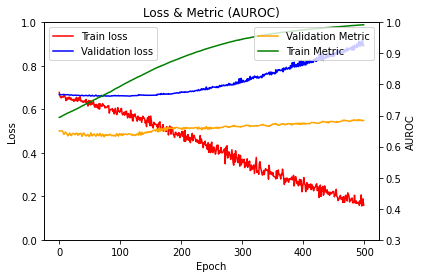

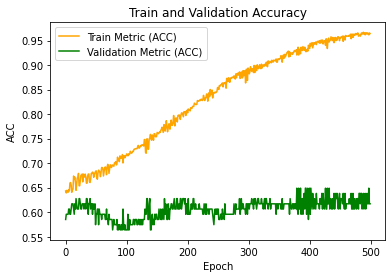

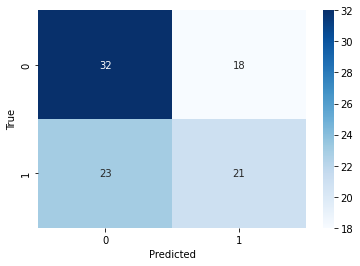

: 

In [31]:
fig, ax1 = plt.subplots()
ax1.plot(np.array(loss_values), color='red',label='Train loss')
ax1.plot(np.array(val_loss_values), color='blue', label='Validation loss')
ax1.set_ylim(0, 1)
ax1.legend(loc='upper left')
ax2 = ax1.twinx()
ax2.plot(np.array(val_auc_list), color='orange',label='Validation Metric')
print(np.shape(np.array(train_auc_list)))
ax2.plot(np.array(train_auc_list), color='green',label='Train Metric')
ax2.set_ylim(0.3, 1)
plt.title('Loss & Metric (AUROC)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax2.set_ylabel('AUROC')
ax2.legend(loc='upper right')
plt.show()
plt.close

#accuracy plot
plt.plot(np.array(train_acc_list), 'orange',label='Train Metric (ACC)')
plt.plot(np.array(val_acc_list), 'green', label='Validation Metric (ACC)')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('ACC')
plt.legend()
plt.show()
plt.close()

#confusion matrix plot 

sns.heatmap(test_cm_list[np.array(val_loss_values).argmin()], annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
plt.close()